In [124]:
import pandas as pd
from bertopic import BERTopic
from sklearn.model_selection import train_test_split
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# Preporcessing



In [73]:
merged_dataframe = pd.read_csv('merged_dataframe.csv')
merged_sentences = pd.read_csv('merged_sentences.csv')
merged_dataframe

,annotation_category,annotation,entity,sentence,entity_atomized,sentiment,tsc_sentiment,blame,praise
0,blame,"new arms deliveries to Kiev are aimed at ""prol...",US,Speaking to the Rossiya-1 state television cha...,US,-1,0,1,0
1,blame,has been sending more advanced and heavier wea...,US,"From the beginning, the US has been sending mo...",US,-1,0,1,0
2,blame,clearly knows that a prolonged conflict betwee...,US,The US clearly knows that a prolonged conflict...,US,1,0,1,0
3,blame,has put its national interests into considerat...,US,The US has put its national interests into con...,US,1,0,1,0
4,blame,"With self-interests in mind, the US will not s...",US,"With self-interests in mind, the US will not s...",US,-1,0,1,0
...,...,...,...,...,...,...,...,...,...
406,blame,"US inflation will become higher, ordinary peop...",If the US does prohibit oil exports to China,The US only has itself to blame for the curren...,US,-1,0,1,0
407,blame,"US inflation will become higher, ordinary peop...",If the US does prohibit oil exports to China,The US only has itself to blame for the curren...,China,-1,-1,1,0
408,blame,"would undermine US oil companies, and they wil...",Prohibiting the export of oil and petroleum pr...,Prohibiting the export of oil and petroleum pr...,US,-1,0,1,0
409,blame,"would undermine US oil companies, and they wil...",Prohibiting the export of oil and petroleum pr...,Prohibiting the export of oil and petroleum pr...,China,-1,-1,1,0


In [68]:
#drop duplicates
merged_dataframe = merged_dataframe.drop_duplicates(subset= ['sentence', 'annotation_category'])
merged_dataframe = merged_dataframe.sample(frac=1).reset_index(drop=True)
merged_dataframe

,annotation_category,annotation,entity,sentence,entity_atomized,sentiment,tsc_sentiment,blame,praise
0,blame,"is ""causing a deterioration of the security en...",the Russia-Ukraine conflict,"On Tuesday, Japanese and NATO officials agreed...",Russia,1,-1,1,0
1,blame,it will be difficult for the EU to truly becom...,If the US-led value alliance dominates the dev...,If the US-led value alliance dominates the dev...,US,1,-1,1,0
2,blame,may risk triggering a global recession,US-led interest rate hikes,"Compared with those eurozone countries, more e...",US,-1,-1,1,0
3,blame,have chosen to follow the US to attack China o...,Japan and Australia,Only states like Japan and Australia have chos...,Australia,1,1,1,0
4,blame,was stepping up its efforts to recruit members...,US,Previous reports show that the Russian Foreign...,US,-1,-1,1,0
...,...,...,...,...,...,...,...,...,...
245,blame,has ramped up efforts to link the Russia-Ukrai...,Washington,The Chinese defense minister's remarks stresse...,Washington,-1,0,1,0
246,blame,has frequently used the Taiwan question to pro...,Washington,The allegation was soon clarified by a former ...,Washington,-1,1,1,0
247,blame,Europe's problems are the world's problems,Europe,"However, Jaishankar went so far as to complain...",Europe,-1,0,1,0
248,blame,"Japan and China have been in ""opposing camps"" ...",Japan,"According to Japanese media, Japan and China h...",Japan,-1,0,1,0


In [82]:
#full dataset
full_df = merged_dataframe[['sentence', 'blame', 'praise', 'annotation_category']]
full_df = merged_sentences.merge(full_df, left_on='sentence', right_on='sentence', how='left')
full_df = full_df.fillna(0)
full_df['blame'] = full_df['blame'].astype(int)
full_df['praise'] = full_df['praise'].astype(int)
#map annotation category
full_df['annotation_category'] = full_df['annotation_category'].apply(lambda x: -1 if x == 'blame' else 1 if x =='praise' else 0)
full_df

,sentence,blame,praise,annotation_category
0,Speaking to the Rossiya-1 state television cha...,1,0,-1
1,"""Putin's remarks came a few days after US Pres...",0,0,0
2,"""Putin did not specify which targets he meant.",0,0,0
3,"Song Zhongping, a Beijing-based military exper...",0,0,0
4,"From the beginning, the US has been sending mo...",1,0,-1
...,...,...,...,...
12960,"That must be respected, as we would expect Chi...",0,0,0
12961,"Of course, one can have opinions on these things.",0,0,0
12962,One can even make criticisms if one wants.,0,0,0
12963,But they shouldn't interfere in state relation...,0,0,0


In [111]:
#balanced dataset
blame_df = full_df[full_df['annotation_category'] == -1]
praise_df = full_df[full_df['annotation_category'] == 1]
neutral_df = full_df[full_df['annotation_category'] == 0]
min_size = min(len(blame_df), len(praise_df))
max_size = max(len(blame_df), len(praise_df))

neutral_sampled = neutral_df.sample(max_size, random_state=42)
full_balanced_df = pd.concat([blame_df, praise_df, neutral_sampled], ignore_index=True)
full_balanced_df = full_balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
#full_balanced_df = full_balanced_df.drop_duplicates(subset= ['sentence', 'annotation_category'])

#summarize the balanced dataset
print(f"Blame: {sum(full_balanced_df['annotation_category'] == -1)}")
print(f"Praise: {sum(full_balanced_df['annotation_category'] == 1)}")
print(f"Neutral: {sum(full_balanced_df['annotation_category'] == 0)}")
full_balanced_df


Blame: 296
Praise: 118
Neutral: 296


In [112]:
#Train test split
y =  full_balanced_df['annotation_category']
docs = full_balanced_df['sentence']
X_train, X_test, y_train, y_test = train_test_split(docs, y, test_size=0.2, random_state=42)

# Modeling

In [128]:
#classifiers
classifiers = [
    LogisticRegression(),
    LinearDiscriminantAnalysis(),
    SVC(),
    DecisionTreeClassifier(),
    MLPClassifier(max_iter=10000),
]
classifiers_names = [
    'Logistic Regression',
    'Linear Discriminant Analysis',
    'Support Vector Classification',
    'Decision Tree Classifier',
    'MLP Classifier',
]

y_preds = []


In [144]:
for clf in tqdm(classifiers):
        empty_dimensionality_model = BaseDimensionalityReduction()
        ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

        topic_model= BERTopic(
        umap_model=empty_dimensionality_model,
        hdbscan_model=clf,
        ctfidf_model=ctfidf_model
        )
        topics, probs = topic_model.fit_transform(list(X_train), y=list(y_train))
        y_predicted, probs_predicted  = topic_model.transform(list(X_test))
        y_preds.append(y_predicted)

100%|██████████| 5/5 [01:23<00:00, 16.68s/it]


In [120]:

print(f"Blame: {sum(x == -1 for x in y_predicted)}")
print(f"Praise: {sum(x == 1 for x in y_predicted)}")
print(f"Neutral: {sum(x == 0 for x in y_predicted)}")

Blame: 66
Praise: 33
Neutral: 43


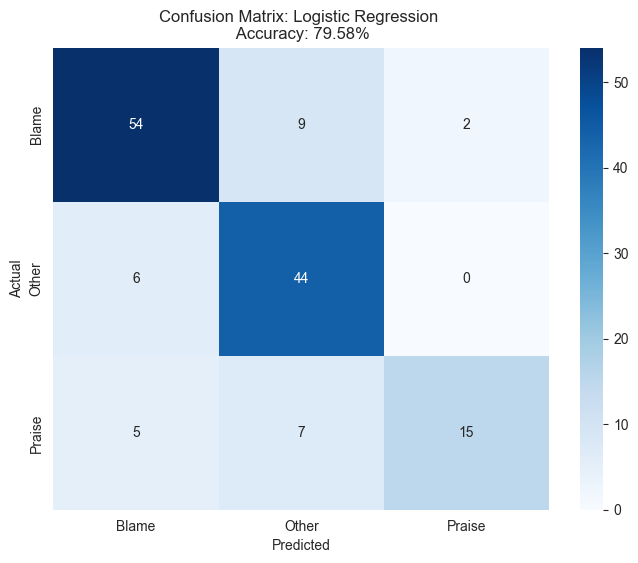

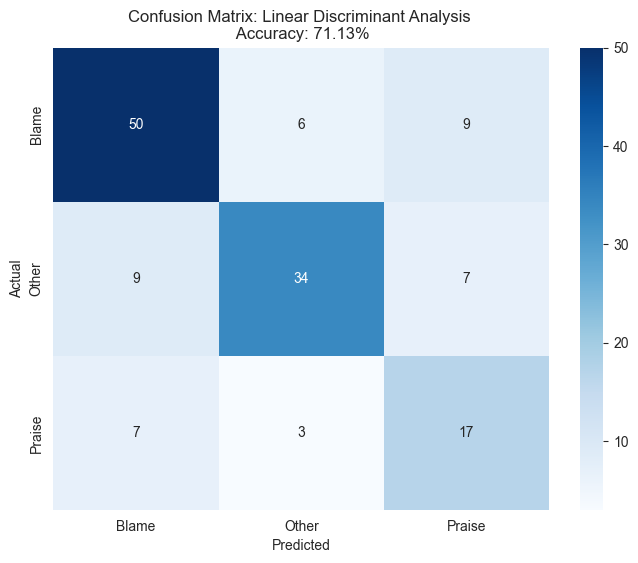

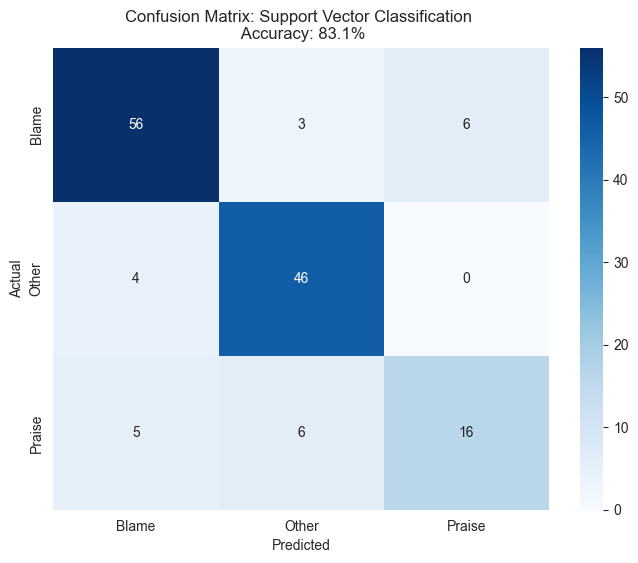

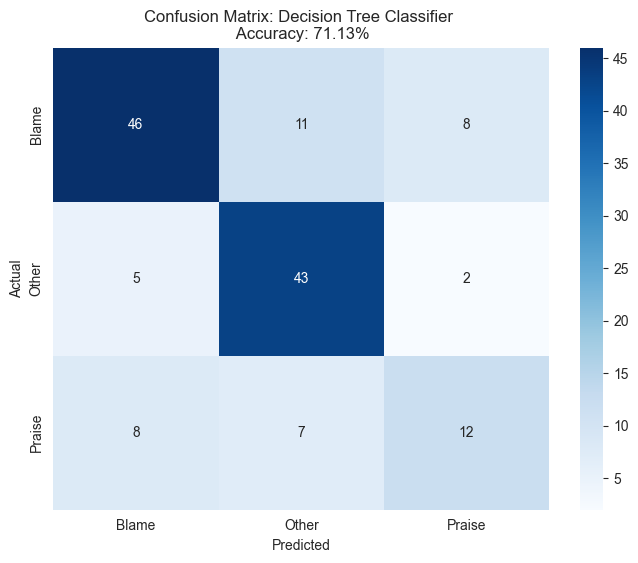

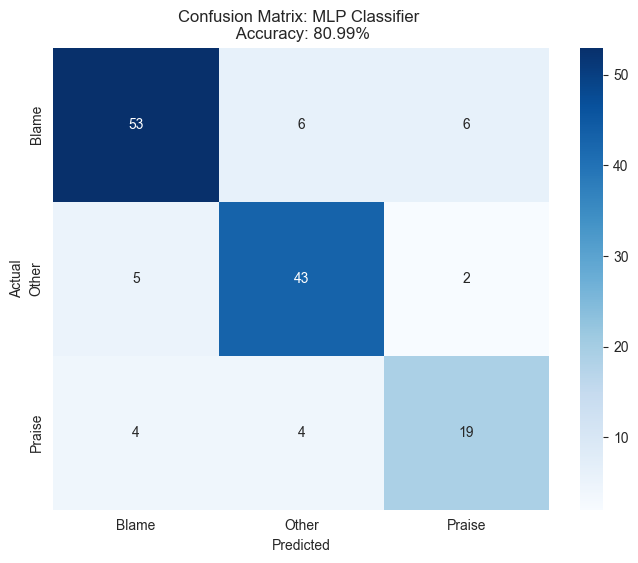

In [145]:
for y_pred, clf_name in zip(y_preds, classifiers_names):
        cm = confusion_matrix(y_test, y_pred)
        accuracy = round(sum(y_test == y_pred) / len(y_test)*100, 2)

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blame', 'Other', 'Praise'], yticklabels=['Blame', 'Other', 'Praise'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Confusion Matrix: {clf_name} \n Accuracy: {accuracy}%')

        plt.show()
#format accuracy to 2 decimal places


# Fine tune SVC

In [148]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'kernel': ['poly'],
    'degree': [2, 3, 4, 5, 6],
}
grid = ParameterGrid(param_grid)

In [149]:
best_accuracy = 0
best_params = None
best_clf = None
for params in tqdm(grid):
    clf = SVC(**params)
    empty_dimensionality_model = BaseDimensionalityReduction()
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

    topic_model= BERTopic(
    umap_model=empty_dimensionality_model,
    hdbscan_model=clf,
    ctfidf_model=ctfidf_model
    )
    topics, probs = topic_model.fit_transform(list(X_train), y=list(y_train))
    y_predicted, probs_predicted  = topic_model.transform(list(X_test))
    accuracy = round(sum(y_test == y_predicted) / len(y_test)*100, 2)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_clf = clf
        print(f"Best accuracy: {best_accuracy}%")
        print(f"Best params: {best_params}")
        print(f"Best clf: {best_clf}")

 20%|██        | 1/5 [00:15<01:03, 15.79s/it]

Best accuracy: 83.1%
Best params: {'degree': 2, 'kernel': 'poly'}
Best clf: SVC(degree=2, kernel='poly')


100%|██████████| 5/5 [01:20<00:00, 16.05s/it]


Text(0.5, 1.0, 'Confusion Matrix: BERTopic + SVC \n Accuracy: 83.1%')

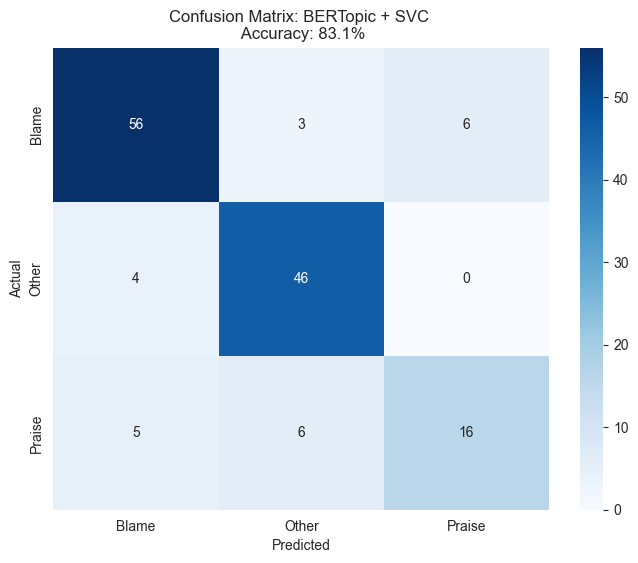

In [152]:
empty_dimensionality_model = BaseDimensionalityReduction()
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

topic_model= BERTopic(
umap_model=empty_dimensionality_model,
hdbscan_model= SVC(),
ctfidf_model=ctfidf_model
)
topics, probs = topic_model.fit_transform(list(X_train), y=list(y_train))
y_predicted, probs_predicted  = topic_model.transform(list(X_test))

cm = confusion_matrix(y_test, y_predicted)
accuracy = round(sum(y_test == y_predicted) / len(y_test)*100, 2)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Blame', 'Other', 'Praise'], yticklabels=['Blame', 'Other', 'Praise'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix: BERTopic + SVC \n Accuracy: {accuracy}%')
